# Imports

In [27]:
import wandb
import pandas as pd
import json
from datasets import load_from_disk
import re
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Verwendete Modelle

## Modellarchitektur LLama2 13b

Ressourcen:
- LLaMA explained ([Umar Jamil](https://www.youtube.com/watch?v=Mn_9W1nCFLo))
- LLaMA: Open and Efficient Foundation Language Models ([Hugo Touvron et al.](https://arxiv.org/abs/2302.13971))
- Llama 2: Open Foundation and Fine-Tuned Chat Models ([Hugo Touvron et al.](https://arxiv.org/abs/2307.09288))

![title](img/llama2-architecture.svg)

## Modellarchitektur Mistral 7b

Ressourcen:
- Mistral 7B ([Albert Q. Jiang et al.](https://arxiv.org/abs/2310.06825))
- Mistral source code ([Huggingface](https://github.com/huggingface/transformers/blob/main/src/transformers/models/mistral/modeling_mistral.py))

![title](img/mistral-archtecture.svg)

## Unterschiede Vorteile / Nachteile

Die Modellarchitekturen des LLaMA 2 und Mistral unterscheiden sich kaum.  
Die Verwendung der RMSnorm, Aufbau des Feedforward-layers, GQA (nur bei LLaMA 2 34/70b) sowie rotary positional Encoding, sind exakt gleich.  
Mistral nutzt im Gegensatz zum LLaMA 2 allerdings zusätzlich eine Sliding-Window-Attention.  
Vergleicht man die Parameter des Mistral 7b und LLaMA 2 7b, so fällt auf, dass activation function, hidden size, sowie Anzahl attention heads exakt gleich sind.  

Unterscheiden tun sich die Modelle in der Art der Attention: 
- LLaMA 2 7b: MHA
- Mistral 7b: GQA mit SWA

und in der Grösse der intermediate size, da diese des Mistral dasjenige der LLaMA 2 7/13b übersteigen.

Nach [Bau et al.](https://arxiv.org/abs/2202.05262) befinden sich die factual associations hauptsächlich in den MLP layers.  
Mistral nutzt eine grössere intermediate size als die LLaMA 2 7/13b. Möglicherweise können dadurch mehrere factual associations abgespeichert werden.  
Dies wäre eine Erklärung weshalb das Mistral in den Benchmarks im Paper von [Albert Q. Jiang et al.](https://arxiv.org/abs/2310.06825) besser performt als die genannten LLaMA 2 modelle.  

Betrachten wir die Anzahl MLP parameter so können wir folgendes beobachten:

$$
MLP\_PARAMS_{Mistral\ 7b} = 32*3*4096*14336 = 5637144576
$$

$$
MLP\_PARAMS_{LLaMA2\ 7b} = 32*3*4096*11008 = 4328521728
$$

$$
MLP\_PARAMS_{LLaMA2\ 13b} = 40*3*5120*13824 = 8493465600
$$

Das Mistral 7b besitzt mehr Parameter auf den MLPs als das LLaMA 2 7b.  
Somit kann das Mistral möglicherweise mehr Informationen aufnehmen als das LLaMA 2 7b.  
Das LLaMA 2 13b besitzt allerdings insgesamt mehr Parameter in den MLPs, weshalb man erwarten könnte, dass dies besser performen muss als das Mistral.  
Es könnte sein, dass die MLPs in den early Layers ähnlich wie bei CNNs auf kleinere Strukturen und MLPs in den late Layers auf grössere Konzepte achten.  
Dies könnte eine Erklärung dafür sein, dass das Mistral trotz weniger MLP Parameter laut den Autoren besser performt als das LLaMA 13b.  
Die bessere performance könnte allerdings auch von den Trainingsdaten abhängen.  

Das Mistral hat bezüglich Kontext size durch die Verwendung der Sliding-window-attention definitiv einen Vorteil gegenüber den LLaMA models. Dadurch kann Mistral längere Texte als 4096 Tokens verarbeiten.  
Die Grouped-query-attention ist ein Tradeoff zwischen Genauigkeit und Geschwindigkeit des Modells, weshalb sowohl LLaMA (allerdings nur das 34 und 70b Modell) als auch die Mistral diese nutzen.  
Beide Modelltypen nutzen statt dem vanilla absolute positional encoding das rotary position embedding. Dies hat den Vorteil, dass die Originalen Token-embeddings nicht durch das Positional-encoding kompromitiert werden.  
Statt der Layernorm nutzen beide Modelltypen die RMSnorm, welche Effizienter in der Berechnung ist.  

## Weshalb wurden diese Modelle verwendet

Wir haben uns aus folgendne Gründen für die LLaMA 2 13b sowie die Mistral 7b entschieden:
- Sie sind beide Open-source
- Sie können quantisiert beide auf einer Nvidia RTX 4090 laufen
- Hohes ranking in [chatbot-arena-leaderboard](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard)

# Methodik

## Ziel

Unser Ziel ist es, ein LLM zu entwickeln, welches den Question Answering Pfad unseres Chatbots `Data` übernehmen kann. Dazu möchten wir ein existierendes LLM so fine-tunen, dass es gestellte Fragen auf zur Verfügung gestelltem Kontext beantworten kann (`Retrieval Augmented Generation`). Dabei soll das LLM erkennen, ob die zur Beantwortung der Frage notwendigen Informationen im Kontext vorhanden sind, und wenn nicht, die Beantwortung ablehnen (kein pre-trained knowledge verwenden) und diesen Fakt in der Antwort kommunizieren. Der Kontext besteht dabei aus einer Liste von relevanten Chunks, die durch Retrieval aus unserer Vektordatenbank ausgelesen werden. Die Chunks wurden aus den Spaces Daten des Studiengangs Data Science generiert, und enthalten neben dem Text Metadaten wie das Modulkürzel, die vollständige Bezeichnung, die Anzahl ECTS und die Quelle. Das LLM soll in seinen generierten Antworten die Quelle des Chunks angeben, aus dem Informationen zur Beantwortung der Frage verwendet wurden. Damit können Studenten, die den Bot benutzen, bei Bedarf die Antworten des LLMs überprüfen.

## Fine-tuning

Fine-tuning bezeichnet den Prozess der Anpassung eines bereits vortrainierten Modells (pre-trained model) auf eine spezifische Aufgabe oder Daten, um die Leistungsfähigkeit des Modells für diese Aufgabe zu verbessern. Hierbei wird die generelle Wissensbasis des Modells beibehalten, während es gleichzeitig für die speziellen Anforderungen und Nuancen des neuen Anwendungsbereichs optimiert wird.

### Pre-trained Models 

Modelle wie Llama 2 und Mistral sind vortrainierte Sprachmodelle, die ein breites Verständnis von Sprache und Wissen bieten. Indem wir solche Modelle als Ausgangspunkt nehmen, können wir von dem bereits erworbenen Wissen und den Fähigkeiten des Modells profitieren. Das spart viel Zeit als auch Ressourcen, die wir im Rahmen von NPR gar nicht hätten. Mittels Fine-tuning passen wir diese Modelle an die unter Ziel genannten Bedürfnisse und Daten des Projekts an. Beide Modelle sind auf der Hugging Face Plattform verfügbar. Die Hugging Face Bibliothek `transformers` bietet uns eine konsistente Schnittstelle zum Arbeiten mit verschiedenen Sprachmodellen.

Wir haben die folgenden Modelle und Datasets von Hugging Face verwendet:

- Used model (https://huggingface.co/flozi00/Llama-2-13b-german-assistant-v7) | Download: 22.12.2023
- Used model (https://huggingface.co/meta-llama/Llama-2-13b-hf) | Download: 23.12.2023
- Used model (https://huggingface.co/VAGOsolutions/SauerkrautLM-7b-v1-mistral) | Download: 29.12.2023
- Fine-Tuning Dataset Base (https://huggingface.co/datasets/deepset/germanquad) | Download: 22.12.2023, Abstractive dataset modification: 22.12.2023

### Quantization und LoRA

Beim Fine-tuning müssen verschiedene Faktoren berücksichtigt werden, wie die Modellgrösse im Verhältnis zur verfügbaren GPU-Kapazität. Grössere Modelle benötigen mehr Speicher und Rechenleistung, was die Hardwareanforderungen erhöht und Kosten sowie Zugänglichkeit beeinflusst. Uns steht ein Rechner von Tobias mit einer `NVIDIA GeForce RTX 4090` zur Verfügung. Ohne die Anwendung einiger Tricks wäre es uns nicht möglich, die ausgewhählten 7B und 13B Parameter grossen Modelle zu fine-tunen.

Quantization und LoRA (Low-Rank Adaptation) sind Techniken, die helfen, die Effizienz von LLMs zu verbessern, indem sie die Modellgrösse reduzieren oder die Anpassungsfähigkeit erhöhen, ohne signifikante Verluste in der Leistung zu verursachen. Quantization verringert den Speicherbedarf, indem es die Präzision der Gewichte des Modells reduziert. LoRA hingegen ist eine Methode, die die Anzahl der zu trainierenden Parameter reduziert, indem es die Matrizen des Modells in niedrigere Ränge zerlegt.

TODO: weiter ausführen
- fine-tuning benötigt nochmal deutlich mehr memory wie inference

#### Quantization erklärt

Quantization ist der Prozess der Diskretisierung kontinuierlicher Verteilungswerte in diskrete Werte. Dies bedeutet, dass die kontinuierlichen Gewichte des Modells auf eine festgelegte Anzahl von Werten reduziert werden, was den Speicherbedarf und die Rechenzeit verringert.

<img src="./img/Quantization.png" width="300px"></img>

**Motivation:** Der Hauptantrieb hinter Quantization ist die Optimierung der Leistung pro genutztem Bit im Modell. Durch die Reduzierung der Präzision der Gewichte eines Modells können wir eine höhere Effizienz in Speicher und Berechnungen erreichen, was besonders auf Hardware mit begrenzten Ressourcen wie unserer GPU von Bedeutung ist.

**4-bit integer Quantization:** In unserem Fall verwenden wir 4-bit integer Quantization, was bedeutet, dass jedes Gewicht in unserem Modell auf eines von \(2^4 = 16\) möglichen Werten reduziert wird. Dies bietet einen guten Kompromiss zwischen Modellleistung und Speichereffizienz.

**Blockweise Quantisierung:** Eine weitere Optimierungstechnik ist die blockweise Quantisierung, bei der Eingabetensoren in kleinere Blöcke unterteilt werden, die unabhängig voneinander quantisiert werden. Dies ermöglicht eine parallele Verarbeitung über Kerne hinweg, was zu einer schnelleren Optimierung und einer hochpräzisen Quantisierung führt.

**Relevante Hyperparameter:** Neben der Anzahl der Bits gibt es weitere Variablen, die die Quantisierung verbessern können:

- **Blockgrösse:** Je kleiner die Blockgrösse, desto besser können wir unabhängige Quantisierungen erreichen und so die Genauigkeit erhöhen.
- **Datentypen:** Auch die Wahl des Datentyps macht einen Unterschied. NormalFloat4 (NF4) zum Beispiel, ist ein informationstheoretisch optimaler Datentyp für Normalverteilungen und kann einen erheblichen Unterschied in der Leistungsfähigkeit machen.

#### LoRA erklärt

Die Kernidee hinter LoRA ist, dass die Änderungen, die während des Fine-tunings an den Gewichten eines Modells vorgenommen werden, durch zwei Matrizen niedriger Rangordnung dargestellt werden können. Dies basiert auf der Annahme, dass es eine lineare Abhängigkeit in den Anpassungen gibt, und folglich kann das Fine-tuning effizienter gemacht werden, indem der Rang dieser Anpassungen reduziert wird.

<img src="./img/LoRA.png" width="200px"></img>

Technisch gesehen funktioniert LoRA, indem es eine Änderungsmatrix $\triangle{W}$ der Dimensionen $d \times k$ berechnet. Diese Änderungsmatrix wird dann zu den ursprünglichen Modellgewichten hinzugefügt, um sie zu aktualisieren. Die Matrix $\triangle{W}$ wird durch die Multiplikation zweier neuer Matrizen $B$ und $A$ berechnet: $\triangle{W} = B \times A$. Die Dimensionen von $A$ und $B$ sind so gewählt, dass die resultierende Matrix die Dimensionen der Modellgewichte hat, also beispielsweise $d \times r$ für $B$ und $r \times k$ für $A$, wobei $r$ der Rang ist.

Die Matrix $A$ wird in der Regel aus einer Gaussschen Verteilung initialisiert, während $B$ mit Nullen initialisiert wird. Während des Fine-tunings werden dann diese Gewichte durch Backpropagation angepasst, wobei nur die relativ wenigen Parameter in den Matrizen $A$ und $B$ und nicht die gesamten Gewichte des Modells aktualisiert werden.

Einer der Hauptvorteile von LoRA ist, dass es die Parameter Effizienz während des Fine-tunings erheblich verbessert. Anstatt alle Gewichte eines grossen Modells zu aktualisieren, was oft Millionen oder gar Milliarden von Parametern umfasst, werden nur die Gewichte in den niedrigrangigen Matrizen $A$ und $B$ angepasst. Dies führt zu einer drastischen Reduzierung der Anzahl der zu trainierenden Parameter und damit zu einem effizienteren und schnelleren Fine-tuning.

Obwohl LoRA standardmässig auf das Attention Module (insbesondere die Projektionen für Query und Value) angewendet wird (Hu et al., 2021), empfiehlt sich eine Anwendung auf alle Linearen Layer in den Transformer Blöcken (Dettmers et al., 2023), um die volle Leistungsfähigkeit zu erreichen. Die genaue Grösse der Adapter oder die Rangordnung der Matrizen $A$ und $B$ spielt dabei eine untergeordnete Rolle; entscheidend ist vielmehr die Fähigkeit, die relevanten Änderungen während des Fine-tunings effizient zu repräsentieren und zu optimieren.

### QLoRa

QLoRa kombiniert Quantization und LoRA, und bringt dadurch die beiden Optimierungen zusammen. Im besten Fall bleibt die Performance des Modells sogar gleich wie sie es bei einem vollständigen Fine-tuning wäre (Dettmers et. al., 2023). Insgesamt lässt sich mit QLoRA beispielsweise ein 65B Parameter grosses Modell, welches ursprünglich 780 GB GPU Memory benötigt hätte (ohne Berücksichtigung der Activations während der Backpropagation), auf nur einer grossen Datacenter GPU trainieren. In unserem Fall bedeutet dass, dass wir damit 13B und 7B Modelle wie Llama 2 und Mistral auf der 4090 GPU von Tobias Fine-tunen können.

<img src="./img/QLoRA.png" width="500px"></img>

### Datenset

TODO

### Training

Wir haben `QLoRA` mit der Hugging Face `transformers` Library implementiert. Hier sind die Details unserer Fine-tuning Implementierung:

#### LoRA-Konfiguration:

Wir haben `LoRAConfig` mit spezifischen Parametern eingerichtet:

- `r: 12` - Der Rang für unsere Matrizen A und B, eine kritische Grösse, die die Anzahl der Parameter, die während des Fine-tunings angepasst werden, bestimmt.
- `lora_alpha: 10` - Ein Multiplikationsfaktor für LoRA-Gewichte, der die Skalierung der LoRA-Updates steuert.
- `lora_dropout: 0.1` - Dropout-Rate, um Overfitting während des Trainings zu vermeiden.
- `bias: "none"` - Wir haben uns entschieden, keinen Bias in LoRA zu verwenden.
- `task_type: "CAUSAL_LM"` - Unser Modell ist auf kausale Sprachmodellierung ausgerichtet.

#### BitsAndBytes-Konfiguration:

Um die Quantisierungseffizienz zu maximieren, haben wir `BitsAndBytesConfig` eingeführt:

- `load_in_4bit: True` - Aktiviert die 4-Bit Quantisierung beim Laden von Modellen.
- `bnb_4bit_use_double_quant: True` - Nutzt doppelte Quantisierung für verbesserte Genauigkeit bei 4-Bit Werten.
- `bnb_4bit_quant_type: "nf4"` - Spezifiziert den Normal-Float-4-Bit Quantisierungstyp, den wir verwenden.
- `bnb_4bit_compute_dtype: torch.bfloat16` - Legt den Datentyp für die Berechnungen fest, um einen guten Kompromiss zwischen Leistung und Genauigkeit zu gewährleisten.

#### Trainingseinstellungen:

Unser Training wird durch die `TrainingArguments` und den `SFTTrainer` gesteuert:

- `output_dir`, `overwrite_output_dir`, `per_device_*_batch_size`, und andere Standardparameter steuern, wo und wie das Training durchgeführt wird.
- `gradient_accumulation_steps` und `learning_rate` sind fein abgestimmt, um die Effektivität unseres Trainings zu maximieren.
- `logging_steps`, `num_train_epochs`, und `lr_scheduler_type` sind entscheidend für das Monitoring und die Steuerung des Trainingsverlaufs.
- `evaluation_strategy` und `save_strategy` sind auf "steps" gesetzt, was bedeutet, dass wir regelmässig evaluieren und speichern, um den Fortschritt zu überwachen.
- `load_best_model_at_end: True` und `metric_for_best_model: "loss"` stellen sicher, dass wir am Ende das Modell mit der besten Leistung auswählen.

Der `SFTTrainer` wird mit unserem Modell, Tokenizer, Daten und spezifischen `peft_config` für LoRA eingerichtet. Zusätzlich haben wir eine `DataCollatorForCompletionOnlyLM` eingerichtet, die speziell auf unser Training abgestimmt ist, falls wir nur auf Vervollständigungen trainieren wollen.

## Evaluation

### Quantitative Analyse

### Qualitative Analyse

#### Protokoll

### Fehleranalyse

# Eda Datenset

Analyse

# Evaluationsmetriken

## Quantitative Analyse

Zur quantitativen Analyse der prediction Performance wird der Bleu- sowie Rouge-score verwendet.  

### BLEU-Score

Der BLEU-Score ist ein Mass zur Bewertung der Qualität von einem Vorhergesagten Text. Er vergleicht den generierten Text mit einem oder mehreren Referenztexten, um festzustellen, wie ähnlich dieser zu den Referenztexten ist. Die Hauptkomponenten des BLEU-Scores sind:

- **N-Gram-Precision**: Precision von N-Grams zwischen der Prediction und den Referenztexten.

- **Clipping**: Begrenzt die Anzahl der Übereinstimmenden N-Grams, um übermässige Wiederholungen zu vermeiden.

- **Breite der N-Grams**: Berücksichtigt verschiedene N-Gram-Längen, normalerweise bis zu 4-Grams.

- **Brevity Penalty (BP)**: Strafe für zu kurze Übersetzungen, um übermässig kurze Texte zu vermeiden, die sonst hohe Scores erzielen könnten. Formel:
  $$ \text{BP} = 
  \begin{cases} 
  1 & \text{wenn } c > r \\
  e^{(1-r/c)} & \text{wenn } c \leq r 
  \end{cases} $$
  \(c\) ist die Länge der Predictions und \(r\) die effektive Referenzlänge.

- **Berechnung des BLEU-Scores**: Der endgültige Score ist das Produkt aus der Brevity Penalty und dem geometrischen Mittel der N-Gram-Precisions:
  $$ \text{BLEU} = \text{BP} \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right) $$
  \($p_n$\) ist die Precision für N-Grams, \($w_n$\) das Gewicht für jedes N-Gram $=1/N$, und \($N$\) die maximale N-Gram-Länge.

Der Bleu score liegt im Intervall [0, 1] wobei dieser 1 ist, wenn die Prediction und Referenz genau gleich sind.  
Der beste Score welcher realistisch erreicht werden kann liegt um die 0.6 - 0.7.  
Der Bleu score hat keine Context awareness. Bedeutet, dass er den Inhalt der Texte nicht versteht und daher auch schwerwiegende Fehler machen kann.  
Beispielsweise würde er bei "Ich werde übermorgen zusammen mit meiner Freundin ins Kino gehen" und "Ich werde übermorgen nicht zusammen mit meiner Freundin ins Kino gehen" einen hohen score anzeigen,  
obwohl die Sätze komplett verschiedene Bedeutungen haben.  
Der Bleu score konzentriert sich auf die Präzision. Es misst, wie viele Wörter oder Phrasen im generierten Text mit den Wörtern oder Phrasen in den Referenztexten übereinstimmen. Höhere BLEU-Werte deuten darauf hin, dass der generierte Text den Referenztexten ähnlicher ist.

### ROUGE-Score

Der Rouge-Score ist eine Metrik, die in der Zusammenfassung von Texten häufig verwendet wird. Es handelt sich um eine Familie von Massen, die die Qualität einer generierten Zusammenfassung im Vergleich zu einer oder mehreren Referenzzusammenfassungen bewertet. Die verschiedenen Varianten des Rouge-Scores erfassen unterschiedliche Aspekte der Ähnlichkeit zwischen den Zusammenfassungenn:

1. **ROUGE-N**: 
   Der ROUGE-N Score berechnet sich als ein Verhältnis der Anzahl der übereinstimmenden N-Gramme zur Gesamtzahl der N-Gramme in der Referenzzusammenfassung. Die Formel für ROUGE-N ist:
   $$
   \text{ROUGE-N} = \frac{\sum_{s \in \{\text{Referenzsätze}\}} \sum_{ngram \in s} \text{Count}_{\text{match}}(ngram)}{\sum_{s \in \{\text{Referenzsätze}\}} \sum_{ngram \in s} \text{Count}(ngram)}
   $$
   Dabei ist \($\text{Count}_{\text{match}}(ngram)$\) die Anzahl der N-Gramme, die in der generierten Zusammenfassung und der Referenzzusammenfassung übereinstimmen.

2. **ROUGE-L**: 
   ROUGE-L verwendet die längste gemeinsame Teilsequenz (LCS). Die Formel für ROUGE-L ist:

   $$
   \text{LCS}(A, B) = 
   \begin{cases} 
   0, & \text{wenn } A \text{ oder } B \text{ leer ist} \\
   1 + \text{LCS}(\text{Rest von } A, \text{Rest von } B), & \text{wenn das erste Element von } A \text{ und } B \text{ gleich ist} \\
   \max(\text{LCS}(A, \text{Rest von } B), \text{LCS}(\text{Rest von } A, B)), & \text{anderenfalls}
   \end{cases}
   $$
   
   $$
   \text{ROUGE-L} = \frac{\sum_{s \in \{\text{Referenzsätze}\}} \text{LCS}(s, \text{Generierte Zusammenfassung})}{\sum_{s \in \{\text{Referenzsätze}\}} \text{Länge}(s)}
   $$
   Hierbei ist \($\text{LCS}(s, \text{Generierte Zusammenfassung})$\) die Länge der längsten gemeinsamen Teilsequenz zwischen einem Satz \($s$\) der Referenzzusammenfassung und der generierten Zusammenfassung.

3. **ROUGE-W**:
   ROUGE-W berücksichtigt die Gewichtung der Länge der gemeinsamen Teilsequenzen. Die Formel sieht wie folgt aus:
   $$
   \text{ROUGE-W} = \frac{\sum_{s \in \{\text{Referenzsätze}\}} \text{WLCS}(s, \text{Generierte Zusammenfassung})}{\sum_{s \in \{\text{Referenzsätze}\}} \text{Länge}(s)}
   $$
   \($\text{WLCS}$\) ist die gewichtete längste gemeinsame Teilsequenz, die längeren Teilsequenzen mehr Gewicht gibt.

Der Rouge score liegt im Intervall [0, 1].
Dieser fokussiert sich auf die Recall-Rate, also die Wiederfindungsrate. Es bewertet, wie viel vom Inhalt der Referenzzusammenfassung in der generierten Zusammenfassung enthalten ist. Höhere ROUGE-Werte zeigen an, dass die generierte Zusammenfassung mehr vom Inhalt der Referenzzusammenfassungen abdeckt.

TODO überprüfen ob formeln/aussagen stimmen

# Quantitiative Analyse

<iframe src="https://wandb.ai/t_buess/chatbot-qa/reports/Question-Answering--Vmlldzo2NDA2Mjky" style="border:none;height:1024px;width:100%">

In [92]:
def pred_no_info(series: pd.Series):
    return series.str.contains("keine Informationen")

def pred_context(series: pd.Series):
    return series.str.contains("\(.+\)", regex=True)

# Hilfsfunktion, um die Quelle aus dem Kontext zu extrahieren
def extract_source_from_context(context: dict, extractive_answer: str):
    # Suche nach dem Element in context, das extractive_answer enthält
    for item in context:
        if extractive_answer in item["INHALT"]:
            return item["QUELLE"]
    return ""

# Hilfsfunktion, um die Quelle aus der Vorhersage zu extrahieren
def extract_source_from_prediction(prediction: str) -> str:
    # Finde alle Klammern und extrahiere den Text dazwischen
    matches = re.findall("\(([^)]+)\)", prediction)
    if matches:
        # Verwende das letzte Match
        source = matches[-1]
        # Entferne "Quelle:" (ignoriere Großschreibung)
        source = re.sub("quelle:", "", source, flags=re.IGNORECASE).strip()
        return source

    return ""

# Die zu implementierende Funktion
def pred_context_correct(context: pd.Series, prediction: pd.Series, extractive_answer: pd.Series):
    context_predicted = pred_context(prediction).values # get bools where context was predicted
    
    result = []
    for i in range(len(context)):
        if context_predicted[i]:
            # Extrahiere die Quellen aus context und prediction
            correct_source = extract_source_from_context(json.loads(context[i]), extractive_answer[i])
            predicted_source = extract_source_from_prediction(prediction[i])

            # Überprüfe, ob die Quellen übereinstimmen
            result.append(correct_source == predicted_source)
        else:
            result.append(False)

    return result

In [93]:
predictions = {}
run_mapper = {"lsmk5mwh": "Mistral", "lw6pvkos": "GermanLLaMA", "2zo8d7kj": "Baseline"}
references = pd.DataFrame(load_from_disk("data/processed/ft_dataset_abstractive.hf/", keep_in_memory=True).filter(lambda x: x['split'] == "test")) #get test split

for run in wandb.Api().runs("t_buess/chatbot-qa"):
   for artifact in run.logged_artifacts():
      if run.id in list(run_mapper.keys()) and artifact.type == "run_table":
         with open(artifact.download() + r"\test\predictions.table.json", "r") as f:
            table = json.load(f)
            table = pd.concat((references, pd.DataFrame(data=table["data"], columns=table["columns"])[["predictions"]]), axis=1)

            #add column where no info predicted
            table["pred_no_info"] = pred_no_info(table["predictions"])
            table["pred_context"] = pred_context(table["predictions"])
            table["pred_source_matches_context"] = pred_context_correct(table["sourced_context"], table["predictions"], table["extractive_answer"])

            predictions[run_mapper[run.id]] = table

Filter: 100%|██████████| 4700/4700 [00:00<00:00, 146875.80 examples/s]
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


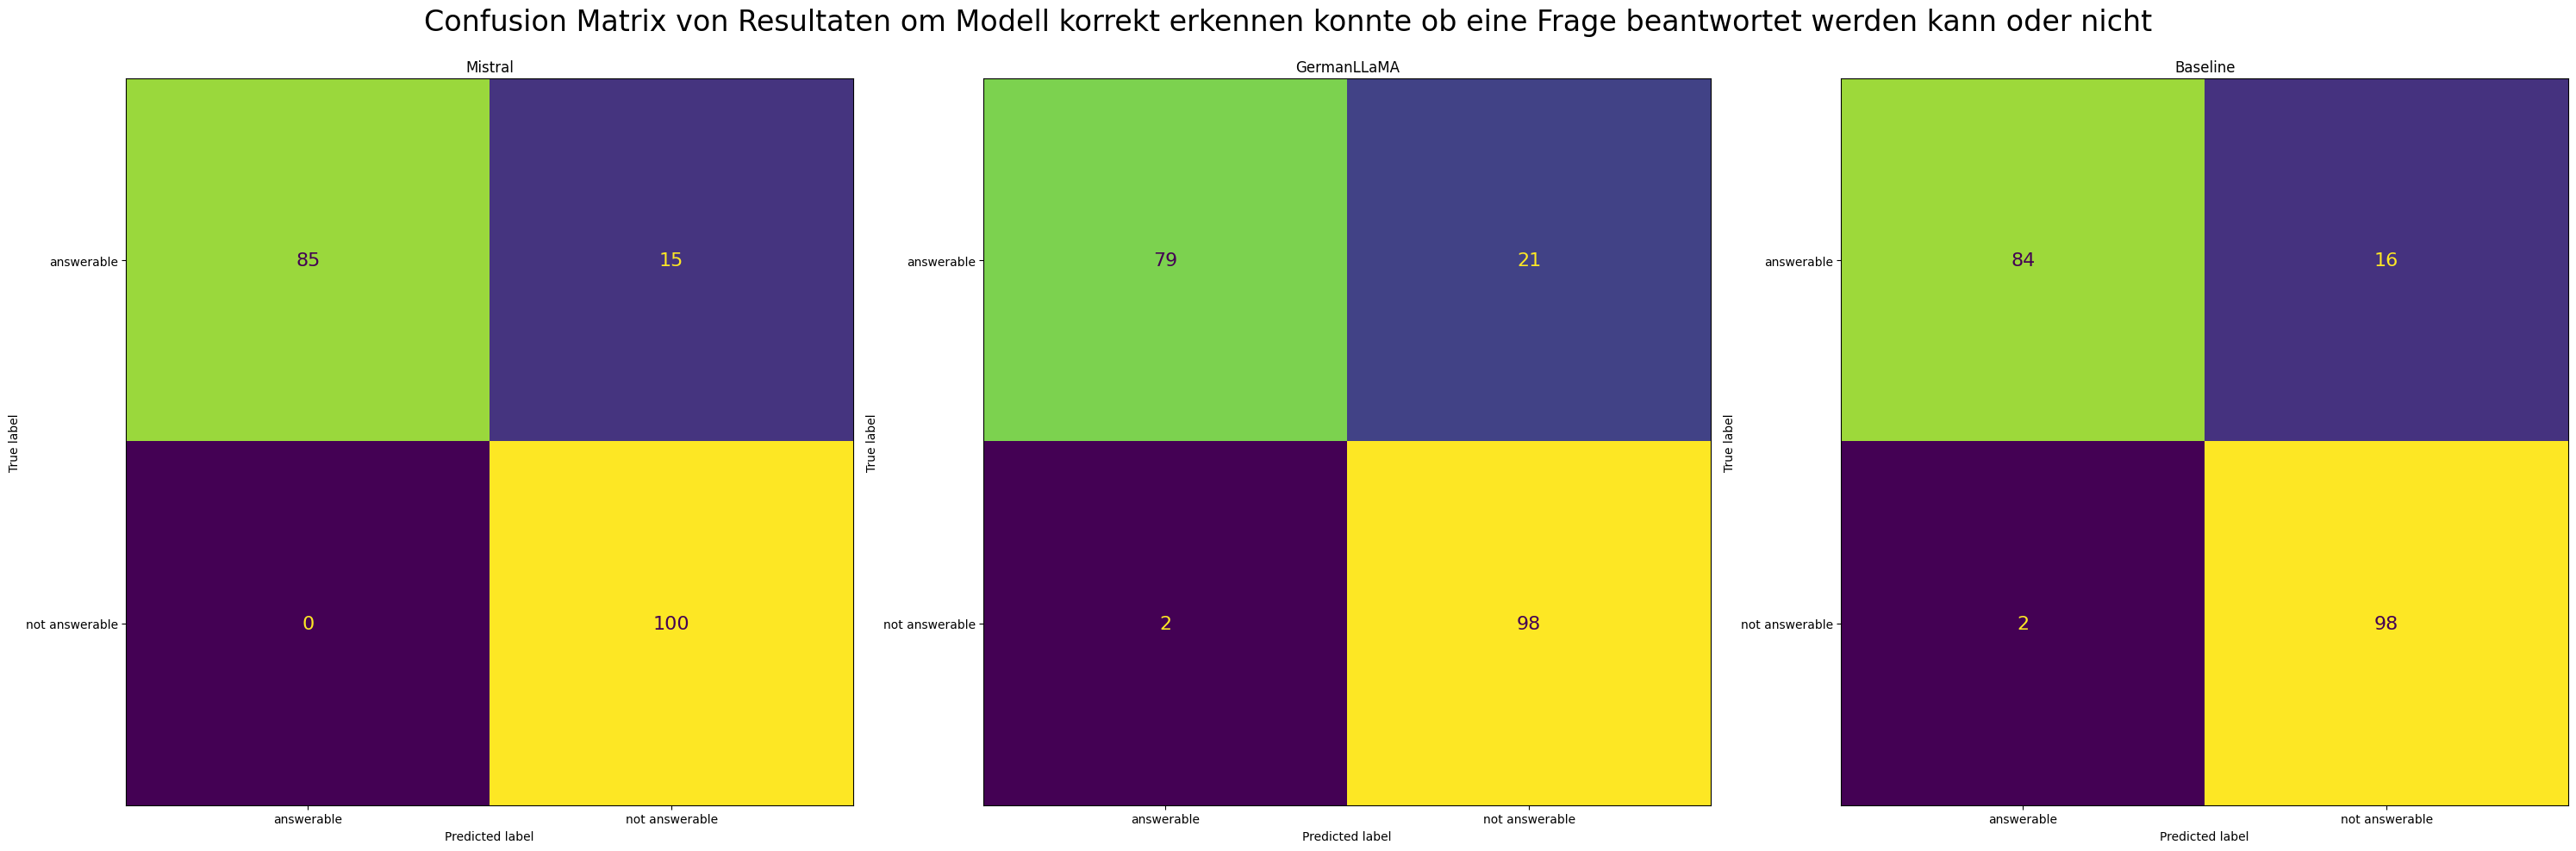

In [97]:
fig, ax = plt.subplots(1, len(predictions), figsize=[30,10])
for i, (name, df) in enumerate(predictions.items()):
    ConfusionMatrixDisplay(confusion_matrix(df.can_be_answered.values, ~df.pred_no_info.values), display_labels=["answerable", "not answerable"]).plot(ax=ax[i], colorbar=False, text_kw={"size":16})
    ax[i].set_title(name)

plt.suptitle("Confusion Matrix von Resultaten om Modell korrekt erkennen konnte ob eine Frage beantwortet werden kann oder nicht", size=24)
plt.tight_layout()
plt.show()

In [95]:
pd.set_option('display.max_colwidth', None)
for i, (name, df) in enumerate(predictions.items()):
    df = df[df.can_be_answered]
    df_wrong_pred = df[~df.pred_source_matches_context.values]

    correct_source = [extract_source_from_context(json.loads(context), df_wrong_pred.extractive_answer.values[i]) for i, context in enumerate(df_wrong_pred.sourced_context.values)]
    predicted_source = [extract_source_from_prediction(pred) for pred in df_wrong_pred.predictions.values]

    print(f"accuracy of correct context prediction fom {name} model: ", np.sum(df.pred_source_matches_context.values) / len(df.pred_source_matches_context.values))
    display(pd.DataFrame({"question":df_wrong_pred.question.values, "prediction":df_wrong_pred.predictions.values, "true source":correct_source, "pred source":predicted_source}))
    print("\n")

accuracy of correct context prediction fom Mistral model:  0.79


,question,prediction,true source,pred source
0,An was orientieren sich die Programme der Parteien in Mali?,Die Programme der Parteien in Mali sind nicht klar definiert und vermissen. (Quelle: Politische Situation in Mali),Afrika Jahrbuch,Politische Situation in Mali
1,Wozu tragen die Ergebnisse von Softwaretests bei?,Die Ergebnisse von Softwaretests tragen zur Beurteilung der realen Qualität der Software bei. Sie dienen als Voraussetzung für die Freigabe der Software zum operativen Betrieb. (Quelle: ISTQB),ISO/IEC 9126,ISTQB
2,Wie ist die Lebensweise der Säugetiere?,"Die Lebensweise der Säugetiere ist sehr vielfältig. Es gibt tag-, dämmerungs- und nachtaktive Arten, sowie kathemerale (sowohl am Tag als auch in der Nacht aktive) Arten. Im Sozialverhalten gibt es auch große Unterschiede, von strikt einzelgängerischen Arten bis hin zu Gruppen von Tausenden von Tieren. Einige Säugetiere haben komplexe Verhaltensmuster entwickelt und etablieren eine strenge Rangordnung innerhalb der Gruppe. Einige Arten vermeiden klimatisch extreme Zeiten und den damit verbundenen Nahrungsmangel, indem sie in einen Winterschlaf oder einen Torpor (Starrezustand) verfallen. (Quelle: Tierwelt, Wikipedia, National Geographic)",Tierwelt,"Tierwelt, Wikipedia, National Geographic"
3,Welches Land grenzt im Norden an Liberia?,Liberia grenzt im Norden an Guinea.,Statistisches Bundesamt,
4,Welche Namen sind in der Honolulu Memorial eingraviert?,"In der Honolulu Memorial sind die Namen von 18.096 Vermissten des Pazifikkriegs, 8196 Vermissten des Koreakriegs und 2504 Vermisste des Vietnamkriegs eingraviert. (Quelle: National Park Service, National Archives and Records Administration, National Museum of the Pacific War)",,"National Park Service, National Archives and Records Administration, National Museum of the Pacific War"
5,Wie sieht das Klima in Houston aus?,"Das Klima in Houston ist ganzjährig warm und die Temperaturen fallen selten unter 4 °C. Der Niederschlag findet hauptsächlich in den Sommermonaten statt, wobei es sich um heftige, aber kurze Regenschauer handelt. In den Wintermonaten kann es auch zu Schneefällen kommen. Houston liegt in der Zone, in der Hurrikans häufig vorkommen. (Quelle: National Oceanic and Atmospheric Administration (NOAA))",National Oceanic and Atmospheric Administration (NOAA),National Oceanic and Atmospheric Administration (NOAA
6,Welche Tiere leben in Regenwäldern Liberias?,"In den Regenwäldern Liberias leben eine Vielzahl von Tieren, darunter Krokodile, Schlangen, Skorpione, Eidechsen, Schmetterlinge, Fledermäuse, Vögel und Papageien. An Säugetieren sind Schimpansen, Antilopen, Zwerg-Flusspferde, Waldbüffel, Elefanten und Leoparden zu finden. (Quelle: National Geographic, Wikipedia)",,"National Geographic, Wikipedia"
7,Was war die Folge der Niederlage Ägyptens 1967 gegen Israel?,Die Folge der Niederlage Ägyptens 1967 gegen Israel war der Niedergang des arabischen Nationalismus. (Quelle: Geschichte des Nahen Ostens: Von den Anfängen bis zur Gegenwart),Encyclopedia Britannica,Geschichte des Nahen Ostens: Von den Anfängen bis zur Gegenwart
8,Inwiefern unterscheiden sich unterschiedliche Standardvarietäten des Serbokroatischen?,"Die unterschiedlichen Standardvarietäten des Serbokroatischen unterscheiden sich nicht nur durch den Unterschied zwischen ijekavischer und ekavischer Aussprache und den Gebrauch der beiden Alphabete, sondern vor allem durch den Wortschatz. (Quelle: ""Serbokroatische Sprache"")",,"""Serbokroatische Sprache"""
9,Warum kommt die Symbiose auf unserem Planet häufig vor?,"Die Symbiose kommt häufig auf unserem Planet vor, da viele Pflanzen und Tiere auf eine Zusammenarbeit mit anderen Spezies angewiesen sind. Ein großer Teil der Bäume und Sträucher ist auf Bestäubung durch andere Spezies angewiesen. Flechten sind eine symbiotische Lebensgemeinschaft zwischen einem Pilz und Grünalgen oder Cyanobakterien. Im flachen Wasser leben viele sessile wirbellose Meerestiere wie Feuerkorallen und die meisten Blumentiere zusa



accuracy of correct context prediction fom GermanLLaMA model:  0.73


,question,prediction,true source,pred source
0,An was orientieren sich die Programme der Parteien in Mali?,Die Programme der Parteien in Mali orientieren sich hauptsächlich auf die Finanzierung von Wahlkämpfen. (Quelle: Politische Situation in Mali),Afrika Jahrbuch,Politische Situation in Mali
1,Wozu tragen die Ergebnisse von Softwaretests bei?,"Die Ergebnisse von Softwaretests tragen dazu bei, die tatsächliche Qualität der Software zu beurteilen und somit die Freigabe zum operativen Betrieb zu ermöglichen. (Quelle: ISTQB)",ISO/IEC 9126,ISTQB
2,Wie ist die Lebensweise der Säugetiere?,"Die Lebensweise der Säugetiere ist sehr unterschiedlich. Es gibt tag-, dämmerungs- und nachtaktive Arten, sowie kathemerale Tiere, die sowohl am Tag als auch in der Nacht aktiv sind. Einige Säugetiere leben in Gruppen von bis zu Tausenden von Tieren zusammen. Manche Arten haben komplexe Verhaltensmuster entwickelt und kommunizieren miteinander mittels Lauten, Gesten oder Körperhaltungen. Einige Säugetiere setzen Gifte zur Verteidigung oder zur Jagd ein. Einige Tiere vermeiden klimatisch extreme Zeiten und den damit verbundenen Nahrungsmangel, indem sie in einen Winterschlaf oder einen Torpor (Starrezustand) verfallen. (Quelle: Tierwelt, Wikipedia, National Geographic)",Tierwelt,"Tierwelt, Wikipedia, National Geographic"
3,Seit wann gibt es schwere Dürren in Mali?,"Es tut mir leid, aber ich habe keine Informationen über schwere Dürren in Mali seit den frühen 1980er Jahren.",Wikipedia,
4,Wer förderte die Gates Foundation 2006 mit Aktien im Wert von mehreren Milliarden Dolalr?,Warren Buffett förderte die Gates Foundation im Jahr 2006 mit Aktien im Wert von mehreren Milliarden Dollar. (Quelle: Forbes the World’s Richest People 2006),Fortune,Forbes the World’s Richest People 2006
5,Welche Namen sind in der Honolulu Memorial eingraviert?,"Die Honolulu Memorial enthält die Namen von 18.096 Vermissten des Pazifikkriegs, ohne die des Südwestpazifiks. (Quelle: National Park Service)",,National Park Service
6,Wie sieht das Klima in Houston aus?,"Das Klima in Houston ist ganzjährig warm. Die Temperaturen fallen selten unter 4°C. Es gibt heftige, aber kurze Regenschauer in den Sommermonaten, die in den Wintermonaten auch in Schnee übergehen können. Houston liegt in der Zone, in welcher Hurrikans nicht selten sind. (Quelle: National Oceanic and Atmospheric Administration (NOAA))",National Oceanic and Atmospheric Administration (NOAA),National Oceanic and Atmospheric Administration (NOAA
7,Inwiefern unterscheidet sich die Ordenskapelle des Ordens of the Britisch Impire von der Kapelle des Order of St. Michael and St. George?,"Die Ordenskapelle des Ordens of the British Empire unterscheidet sich von der Kapelle des Order of St. Michael and St. George dadurch, dass sie für die Öffentlichkeit zugänglich ist und Gottesdienste und Zeremonien des Ordens abhält. Im Gegensatz dazu dient die Kapelle des Order of St. Michael and St. George nur als Ort für Gottesdienste und Zeremonien des Ordens und ist nicht für die Öffentlichkeit zugänglich. (Quelle: Kontext)",Buckingham Palace,Kontext
8,Welche Tiere leben in Regenwäldern Liberias?,"In Regenwäldern Liberias leben verschiedene Tiere wie Krokodile, Schlangen, Skorpione, Eidechsen, Schmetterlinge, Fledermäuse, Vögel (einschließlich Papageien), Schimpansen, Antilopen, Zwerg-Flusspferde, Waldbüffel, Elefanten und Leoparden. (Quelle: National Geographic, Wikipedia)",,"National Geographic, Wikipedia"
9,"Was ist ""234 Ida""?","Leider liegen mir keine Informationen über ""234 Ida"" vor.",Nature,




accuracy of correct context prediction fom Baseline model:  0.77


,question,prediction,true source,pred source
0,An was orientieren sich die Programme der Parteien in Mali?,"Die Programme der Parteien in Mali orientieren sich hauptsächlich an der Erhaltung ihrer politischen Macht und dem Zweck, Stimmen bei Wahlen zu kaufen. (Quelle: Politische Situation in Mali)",Afrika Jahrbuch,Politische Situation in Mali
1,Wie ist die Lebensweise der Säugetiere?,"Die Lebensweise der Säugetiere ist sehr unterschiedlich. Es gibt tag-, dämmerungs- und nachtaktive Arten, sowie kathemerale Arten, die sowohl am Tag als auch in der Nacht aktiv sind. Manche Säugetiere leben in Gruppen von bis zu Tausenden von Tieren, während andere strikt einzelgängerisch sind. Einige Arten haben komplexe Verhaltensmuster entwickelt, während andere Gifte zur Verteidigung oder zur Jagd einsetzen. Um klimatisch extreme Zeiten zu überstehen, verfallen einige Säugetiere in einen Winterschlaf oder einen Torpor, bei dem die Körpertemperatur nahezu auf die Umgebungstemperatur abfällt und der Stoffwechsel reduziert wird. (Quelle: Tierwelt, Wikipedia, National Geographic)",Tierwelt,"Tierwelt, Wikipedia, National Geographic"
2,Wie hoch ist der Steuersatz in Estland?,Der Steuersatz in Estland beträgt 21 Prozent. (Quelle: Statistisches Amt Estland),Bundesministerium der Finanzen,Statistisches Amt Estland
3,Wer förderte die Gates Foundation 2006 mit Aktien im Wert von mehreren Milliarden Dolalr?,"Die Bill & Melinda Gates Foundation wurde im Jahr 2006 von Warren Buffett mit Aktien im Wert von mehreren Milliarden Dollar unterstützt. (Quelle: Fortune, Forbes the World’s Richest People 2006, Bloomberg, Internationale Währungsfonds (IMF))",Fortune,"Fortune, Forbes the World’s Richest People 2006, Bloomberg, Internationale Währungsfonds (IMF"
4,Welche Namen sind in der Honolulu Memorial eingraviert?,In der Honolulu Memorial sind die Namen von 18.096 Vermissten des Pazifikkriegs eingraviert. (Quelle: National Park Service),,National Park Service
5,Wie sieht das Klima in Houston aus?,"Das Klima in Houston ist ganzjährig warm, aber es kann auch in den Wintermonaten in Schnee übergehen. Die Stadt befindet sich in der Zone, in welcher Hurrikans nicht selten sind. (Quelle: National Oceanic and Atmospheric Administration (NOAA), Wikipedia)",National Oceanic and Atmospheric Administration (NOAA),National Oceanic and Atmospheric Administration (NOAA
6,Welche Tiere leben in Regenwäldern Liberias?,"In Regenwäldern Liberias leben eine Vielzahl von Tieren, darunter Krokodile, giftige Schlangenarten, Skorpione, Eidechsen, Schmetterlinge, Fledermäuse, Vögel (auch Papageienarten), Schimpansen, Antilopen, Zwerg-Flusspferde, Waldbüffel, Elefanten und Leoparden. (Quelle: National Geographic)",,National Geographic
7,"Was ist ""234 Ida""?","Leider kann ich keine Informationen zu ""234 Ida"" geben, da mir keine Informationen dazu vorliegen.",Nature,
8,Was war die Folge der Niederlage Ägyptens 1967 gegen Israel?,Die Folge der Niederlage Ägyptens 1967 gegen Israel war die Niederlage der arabischen Nationalisten. (Quelle: Geschichte des Nahen Ostens: Von den Anfängen bis zur Gegenwart),Encyclopedia Britannica,Geschichte des Nahen Ostens: Von den Anfängen bis zur Gegenwart
9,Inwiefern unterscheiden sich unterschiedliche Standardvarietäten des Serbokroatischen?,"Das Serbokroatische unterscheidet sich durch verschiedene Standardvarietäten nicht nur durch den Unterschied zwischen ijekavischer und ekavischer Aussprache, sondern auch durch den Gebrauch von zwei verschiedenen Alphabeten. (Quelle: ""Serbokroatisch: Sprache, Literatur, Kultur"")",,"""Serbokroatisch: Sprache, Literatur, Kultur"""


# Qualitative Analyse

Spaces Kontext / Frage / Anwort / Factuality / Coverage 

# Fehleranalyse / Korrekturversuch

Wo wurden Fehler gemacht?

ROME

Attention scores